### Importing Libraries

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import find_dotenv
from tabulate import tabulate

plt.style.use("bmh")

### Connecting to the Database

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from src.DatabaseConnection import DatabaseConnection

In [3]:
dotenv_path = find_dotenv()

In [4]:
db = DatabaseConnection(dotenv_path)

def fetch_query_results(db, query):
    with db.connection.cursor() as cursor:
        cursor.execute(query)
        return cursor.fetchall()

### DIFFERENCES IN STATISTICS IN DIFFERENT DIVISIONS

In [5]:
query = """
SELECT surrender, COUNT(*) as count
FROM match_data
GROUP BY surrender;
"""

data_surrender = fetch_query_results(db, query)

In [6]:
df_surrender = pd.DataFrame(data_surrender)

df_surrender.columns = ['surrender', 'count']

df_surrender['percentage'] = (df_surrender['count'] / df_surrender['count'].sum()) * 100

print(df_surrender)

   surrender  count  percentage
0          0    701   77.888889
1          1    199   22.111111


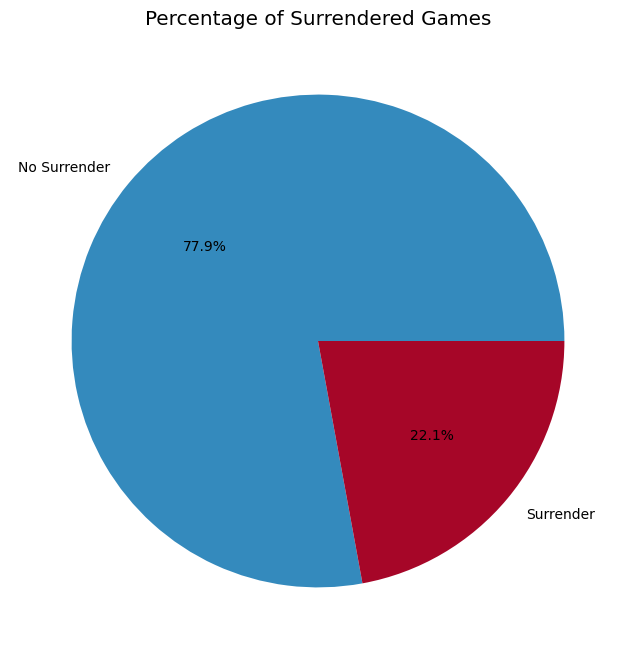

In [7]:
df_surrender['surrender'] = df_surrender['surrender'].map({0: 'No Surrender', 1: 'Surrender'})

plt.figure(figsize=(8, 8))
plt.pie(df_surrender['percentage'], labels=df_surrender['surrender'], autopct='%1.1f%%')
plt.title('Percentage of Surrendered Games')
plt.show()

In [8]:
query = """
SELECT pd.`rank` as division, md.surrender
FROM player_data pd
JOIN match_data md ON pd.match_id = md.match_id;
"""

data_surrender_division = fetch_query_results(db, query)

df_surrender_division = pd.DataFrame(data_surrender_division)

In [9]:
df_surrender_division.columns = ['division', 'surrender']

df_filtered_surrender_division = df_surrender_division[~df_surrender_division['division'].isin(['EMERALD', 'MASTER'])]

surrender_counts = df_filtered_surrender_division.groupby('division')['surrender'].value_counts(normalize=True).unstack().fillna(0) * 100
surrender_counts.columns = ['No Surrender', 'Surrender']

print(surrender_counts)

          No Surrender  Surrender
division                         
BRONZE       75.598086  24.401914
DIAMOND      78.867543  21.132457
GOLD         80.000000  20.000000
IRON         72.814866  27.185134
PLATINUM     78.846154  21.153846
SILVER       80.418251  19.581749
UNRANKED     78.605388  21.394612


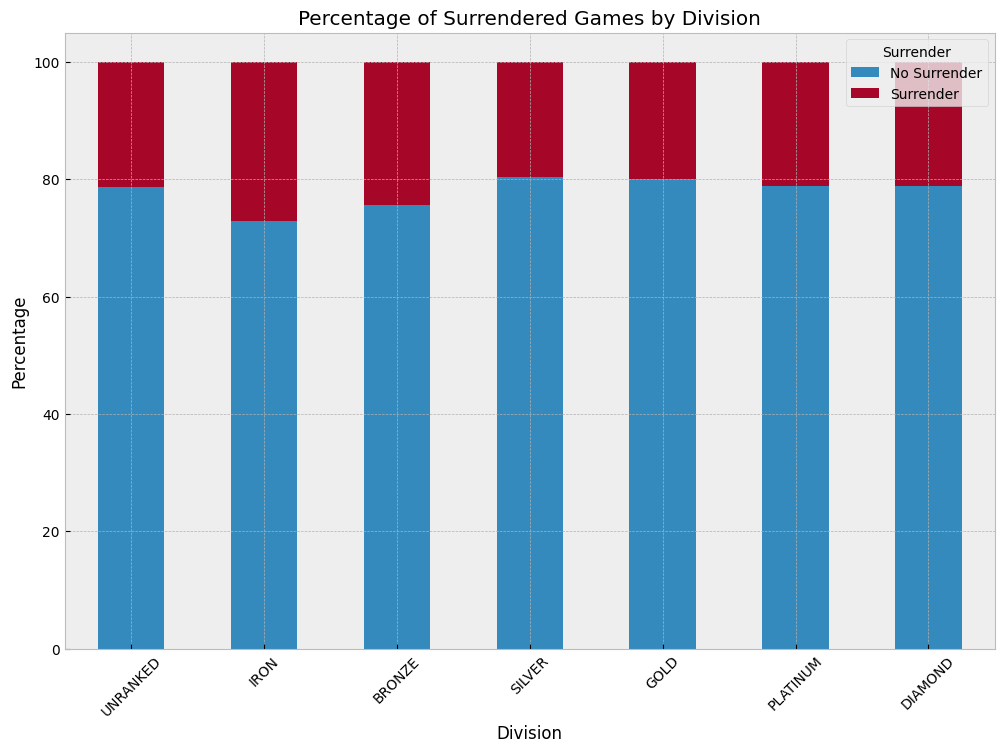

In [10]:
division_order = ['UNRANKED', 'IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']
surrender_counts = surrender_counts.loc[division_order]

surrender_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Division')
plt.ylabel('Percentage')
plt.title('Percentage of Surrendered Games by Division')
plt.legend(title='Surrender')
plt.xticks(rotation=45)
plt.show()

In [11]:
query = """
SELECT pd.`rank` as division, md.game_duration
FROM player_data pd
JOIN match_data md ON pd.match_id = md.match_id;
"""

data_duration = fetch_query_results(db, query)

In [12]:
df_duration = pd.DataFrame(data_duration)

In [13]:
df_filtered_duration = df_duration[~df_duration['division'].isin(['EMERALD', 'MASTER'])]

average_game_length = df_filtered_duration.groupby('division')['game_duration'].mean().reset_index()

average_game_length['division'] = pd.Categorical(average_game_length['division'], categories=division_order, ordered=True)
average_game_length = average_game_length.sort_values('division')

average_game_length = average_game_length.dropna(subset=['division'])

print(average_game_length)

   division  game_duration
6  UNRANKED      28.858935
3      IRON      28.642798
0    BRONZE      28.880190
5    SILVER      29.253643
2      GOLD      28.867213
4  PLATINUM      29.850172
1   DIAMOND      26.438928


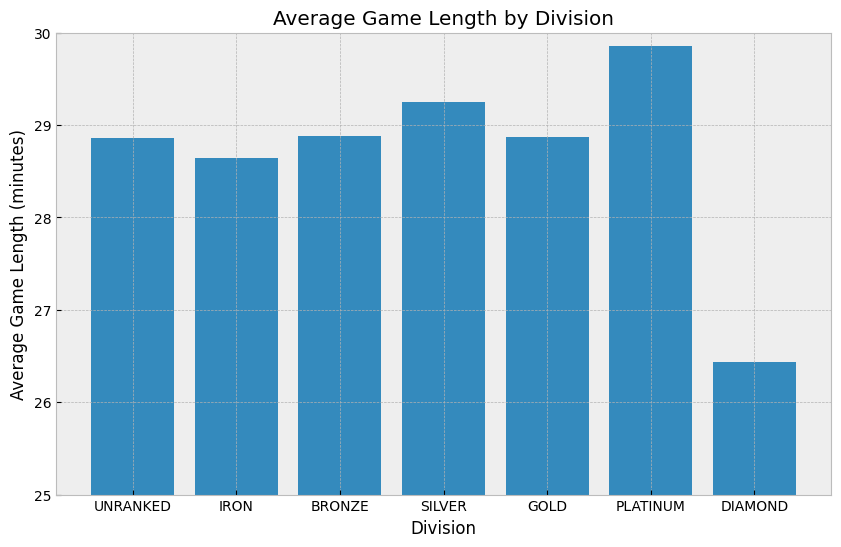

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(average_game_length['division'], average_game_length['game_duration'])
plt.xlabel('Division')
plt.ylabel('Average Game Length (minutes)')
plt.title('Average Game Length by Division')
plt.ylim(25,30)
plt.show()

In [15]:
query = """
SELECT pd.`rank` as division, pd.champion_id, ch.champion_name
FROM player_data pd
JOIN champions ch ON pd.champion_id = ch.champion_id;
"""

data_champion = fetch_query_results(db, query)

df_champion = pd.DataFrame(data_champion)

In [16]:
df_champion.columns = ['division', 'champion_id', 'champion_name']

df_champion['division'] = df_champion['division'].astype(str)

df_filtered_champion = df_champion[~df_champion['division'].isin(['EMERALD', 'MASTER'])]

most_played_champions = df_filtered_champion.groupby('division')['champion_name'].agg(lambda x: x.value_counts().idxmax()).reset_index()

print(most_played_champions)

   division champion_name
0    BRONZE           Lux
1   DIAMOND         Viego
2      GOLD        Thresh
3      IRON           Lux
4  PLATINUM       Caitlyn
5    SILVER          Jinx
6  UNRANKED          Jinx


In [17]:
most_played_champions['division'] = pd.Categorical(most_played_champions['division'], categories=division_order, ordered=True)
most_played_champions = most_played_champions.sort_values('division')

title = "Most Played Champions By Division"
print(title)
print(tabulate(most_played_champions, headers='keys', tablefmt='pretty', showindex=False))

Most Played Champions By Division
+----------+---------------+
| division | champion_name |
+----------+---------------+
| UNRANKED |     Jinx      |
|   IRON   |      Lux      |
|  BRONZE  |      Lux      |
|  SILVER  |     Jinx      |
|   GOLD   |    Thresh     |
| PLATINUM |    Caitlyn    |
| DIAMOND  |     Viego     |
+----------+---------------+


In [18]:
query = """
SELECT pd.`rank` as division, pd.vision_score_per_min
FROM player_data pd;
"""

data_vision = fetch_query_results(db, query)

df_vision = pd.DataFrame(data_vision)

In [19]:
df_vision.columns = ['division', 'vision_score_per_min']

df_filtered_vision = df_vision[~df_vision['division'].isin(['EMERALD', 'MASTER'])]

average_vision_score = df_filtered_vision.groupby('division')['vision_score_per_min'].mean().reset_index()

print(average_vision_score)

   division  vision_score_per_min
0    BRONZE              0.847786
1   DIAMOND              1.017191
2      GOLD              0.931365
3      IRON              0.655871
4  PLATINUM              0.898565
5    SILVER              0.839340
6  UNRANKED              0.851671


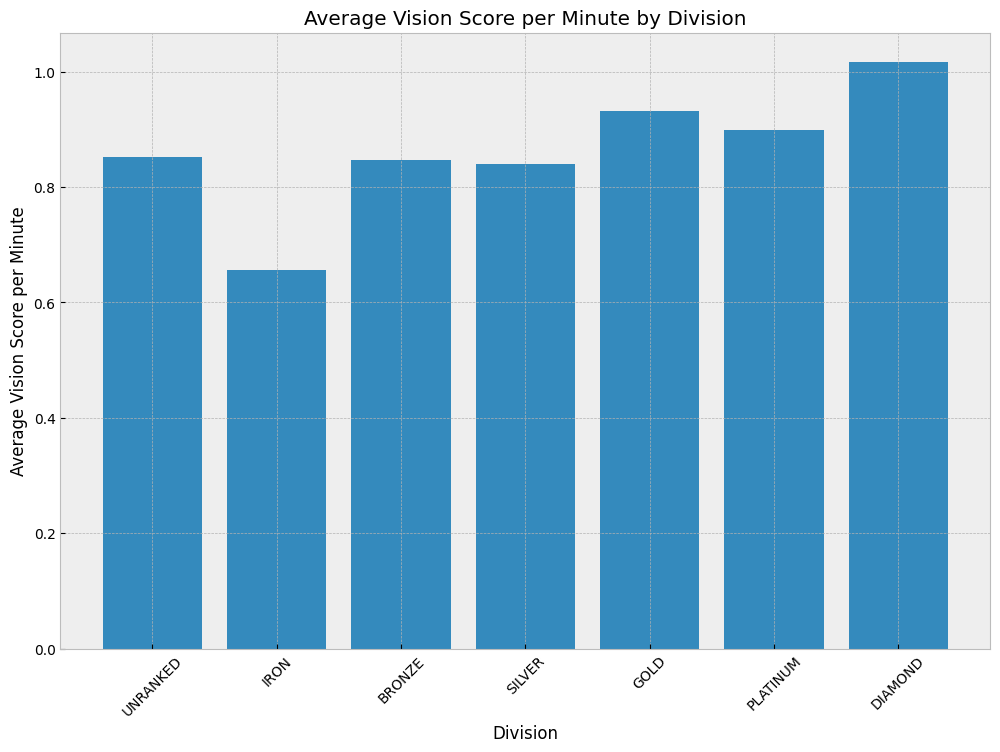

In [20]:
average_vision_score['division'] = pd.Categorical(average_vision_score['division'], categories=division_order, ordered=True)
average_vision_score = average_vision_score.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_vision_score['division'], average_vision_score['vision_score_per_min'])
plt.xlabel('Division')
plt.ylabel('Average Vision Score per Minute')
plt.title('Average Vision Score per Minute by Division')
plt.xticks(rotation=45)
plt.show()

In [21]:
query = """
SELECT pd.`rank` as division, pd.kills, pd.deaths, pd.assists
FROM player_data pd;
"""

data_kda = fetch_query_results(db, query)

df_kda = pd.DataFrame(data_kda)

In [22]:
df_kda.columns = ['division', 'kills', 'deaths', 'assists']

df_filtered_kda = df_kda[~df_kda['division'].isin(['EMERALD', 'MASTER'])].copy()

df_filtered_kda['kda'] = (df_filtered_kda['kills'] + df_filtered_kda['assists']) / df_filtered_kda['deaths'].replace(0, 1)

average_kda = df_filtered_kda.groupby('division')['kda'].mean().reset_index()

print(average_kda)

   division       kda
0    BRONZE  3.360460
1   DIAMOND  3.725525
2      GOLD  3.327140
3      IRON  3.014351
4  PLATINUM  3.436589
5    SILVER  3.085072
6  UNRANKED  3.226110


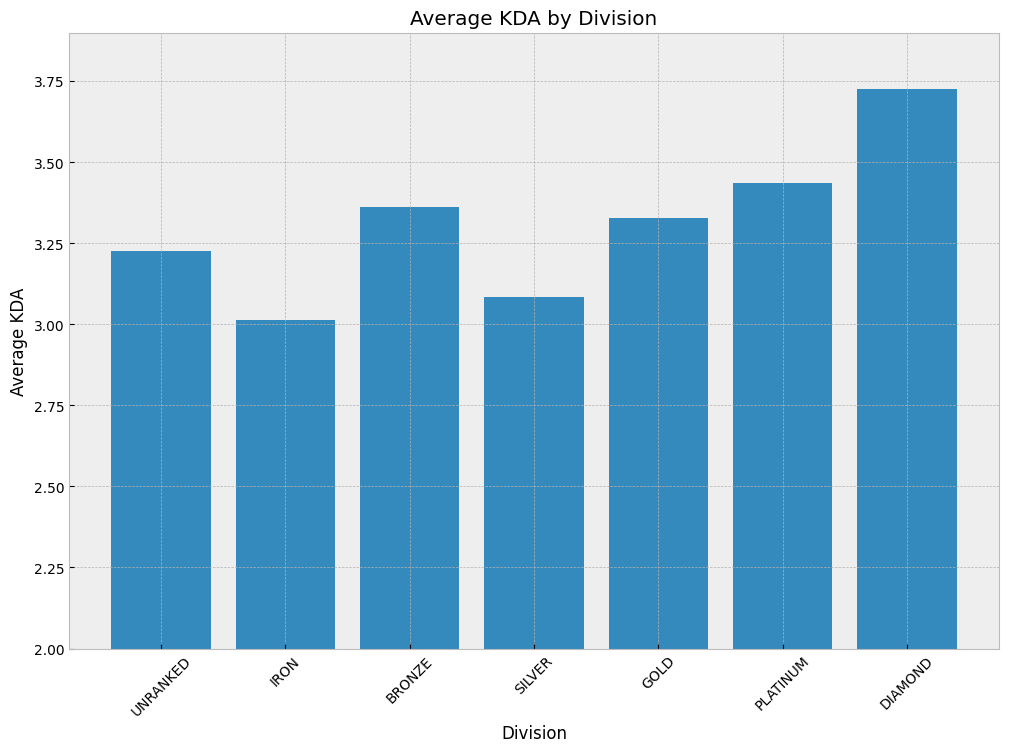

In [23]:
average_kda['division'] = pd.Categorical(average_kda['division'], categories=division_order, ordered=True)
average_kda = average_kda.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_kda['division'], average_kda['kda'])
plt.xlabel('Division')
plt.ylabel('Average KDA')
plt.title('Average KDA by Division')
plt.xticks(rotation=45)
plt.ylim(2.0,3.90)
plt.show()

In [24]:
query = """
SELECT pd.`rank` as division, pd.cs_per_min
FROM player_data pd;
"""

data_cs = fetch_query_results(db, query)

df_cs = pd.DataFrame(data_cs)

In [25]:
df_cs.columns = ['division', 'cs_per_min']

df_filtered_cs = df_cs[~df_cs['division'].isin(['EMERALD', 'MASTER'])]

average_cs = df_filtered_cs.groupby('division')['cs_per_min'].mean().reset_index()

print(average_cs)

   division  cs_per_min
0    BRONZE    3.675400
1   DIAMOND    4.728460
2      GOLD    4.014443
3      IRON    3.508914
4  PLATINUM    4.450812
5    SILVER    4.237825
6  UNRANKED    3.923649


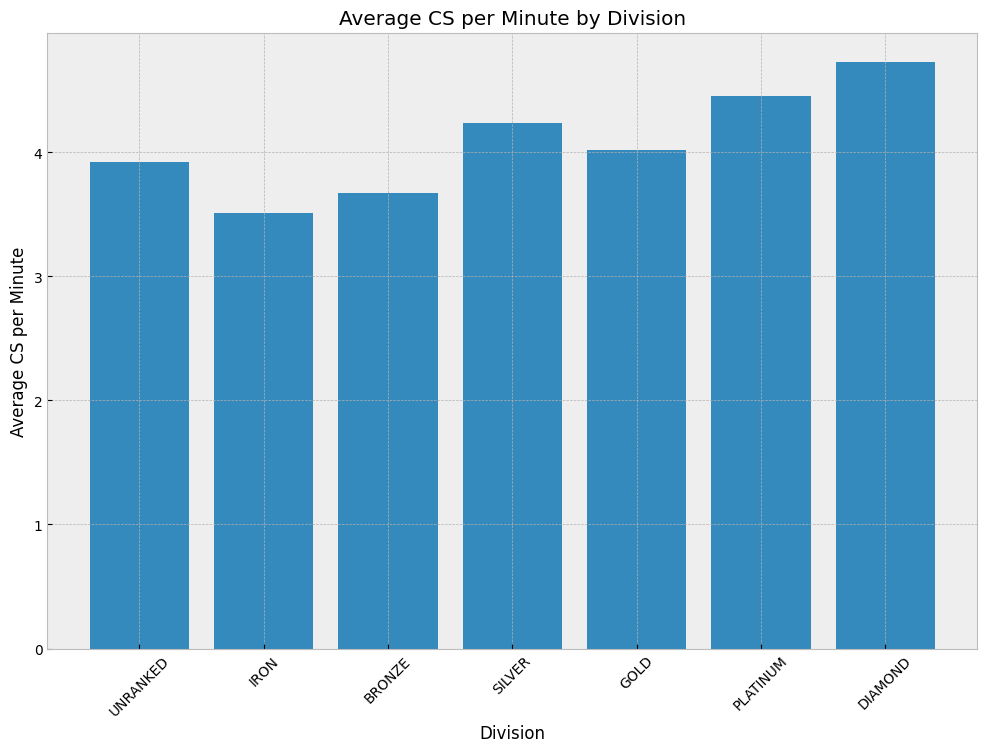

In [26]:
average_cs['division'] = pd.Categorical(average_cs['division'], categories=division_order, ordered=True)
average_cs = average_cs.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_cs['division'], average_cs['cs_per_min'])
plt.xlabel('Division')
plt.ylabel('Average CS per Minute')
plt.title('Average CS per Minute by Division')
plt.xticks(rotation=45)
plt.show()

In [27]:
query = """
SELECT pd.`rank` as division, pd.gold_per_min
FROM player_data pd;
"""

data_gold = fetch_query_results(db, query)

df_gold = pd.DataFrame(data_gold)

In [28]:
df_gold.columns = ['division', 'gold_per_min']

df_filtered_gold = df_gold[~df_gold['division'].isin(['EMERALD', 'MASTER'])]

average_gold = df_filtered_gold.groupby('division')['gold_per_min'].mean().reset_index()

print(average_gold)

   division  gold_per_min
0    BRONZE    379.481806
1   DIAMOND    407.008109
2      GOLD    389.137168
3      IRON    362.295782
4  PLATINUM    405.326081
5    SILVER    391.016374
6  UNRANKED    382.103036


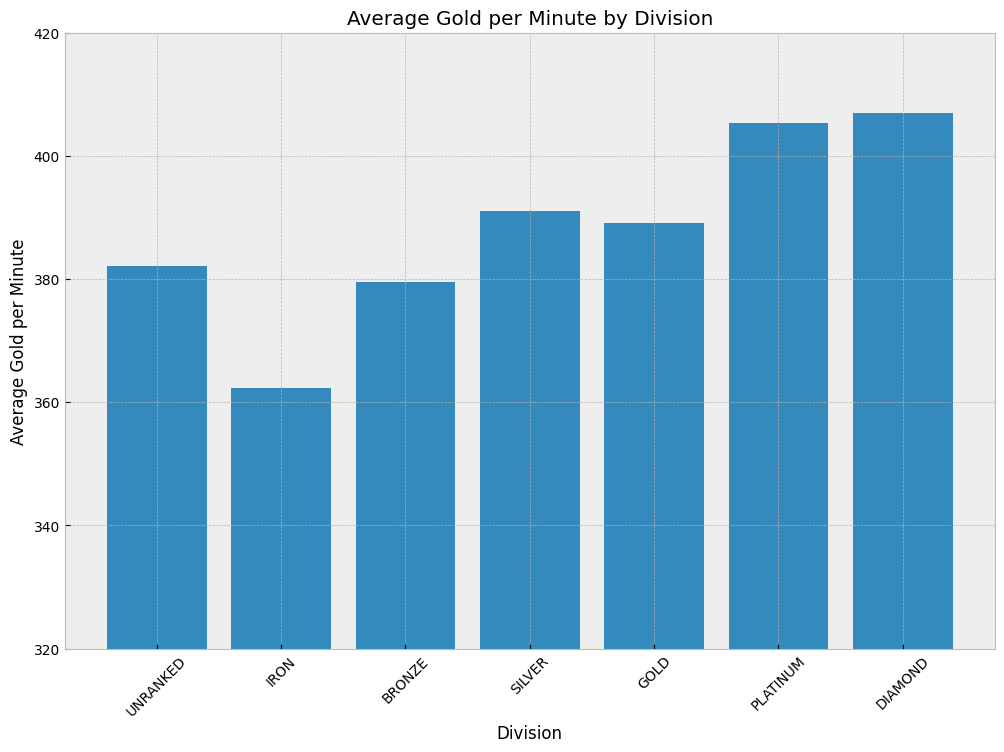

In [29]:
average_gold['division'] = pd.Categorical(average_gold['division'], categories=division_order, ordered=True)
average_gold = average_gold.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_gold['division'], average_gold['gold_per_min'])
plt.xlabel('Division')
plt.ylabel('Average Gold per Minute')
plt.title('Average Gold per Minute by Division')
plt.xticks(rotation=45)
plt.ylim(320,420)
plt.show()

In [30]:
query = """
SELECT pd.`rank` as division, pd.dmg_per_min
FROM player_data pd;
"""

data_dmg = fetch_query_results(db, query)

df_dmg = pd.DataFrame(data_dmg)

In [31]:
df_dmg.columns = ['division', 'dmg_per_min']

df_filtered_dmg = df_dmg[~df_dmg['division'].isin(['EMERALD', 'MASTER'])]

average_damage = df_filtered_dmg.groupby('division')['dmg_per_min'].mean().reset_index()

print(average_damage)

   division  dmg_per_min
0    BRONZE   663.728321
1   DIAMOND   666.984369
2      GOLD   661.214005
3      IRON   622.066201
4  PLATINUM   748.383502
5    SILVER   707.239594
6  UNRANKED   667.482647


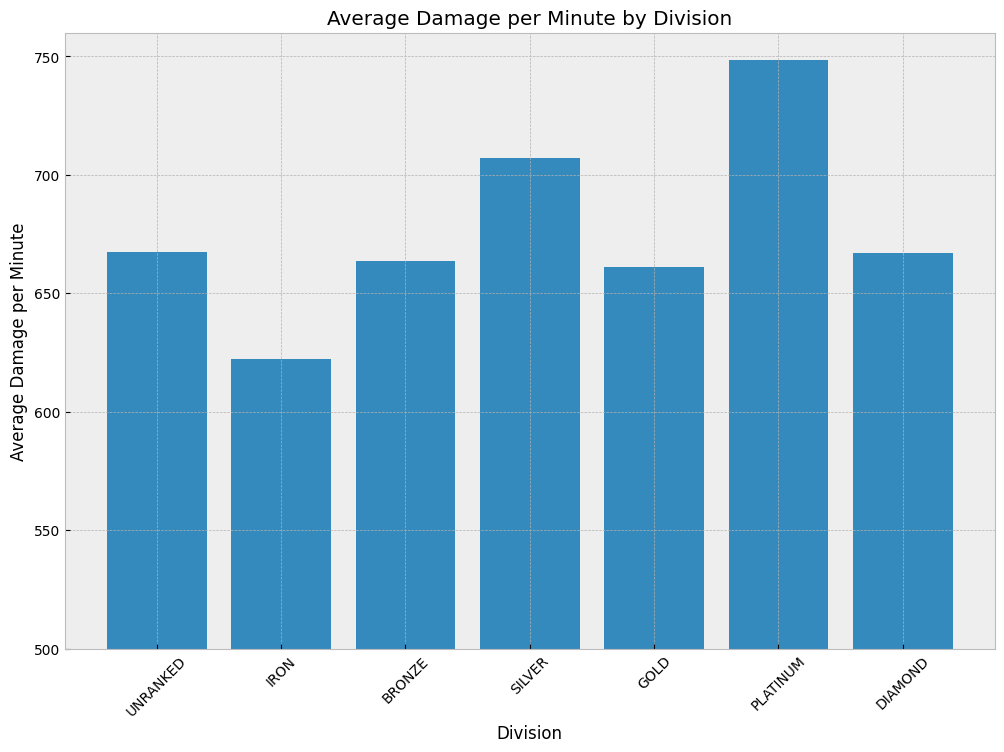

In [32]:
average_damage['division'] = pd.Categorical(average_damage['division'], categories=division_order, ordered=True)
average_damage = average_damage.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_damage['division'], average_damage['dmg_per_min'])
plt.xlabel('Division')
plt.ylabel('Average Damage per Minute')
plt.title('Average Damage per Minute by Division')
plt.xticks(rotation=45)
plt.ylim(500, 760)
plt.show()

In [33]:
query = """
SELECT pd.`rank` as division, pd.dmg_taken_per_min
FROM player_data pd;
"""

data_dmg_taken = fetch_query_results(db, query)

df_dmg_taken = pd.DataFrame(data_dmg_taken)

In [34]:
df_dmg_taken.columns = ['division', 'dmg_taken_per_min']

df_filtered_dmg_taken = df_dmg_taken[~df_dmg_taken['division'].isin(['EMERALD', 'MASTER'])]

average_damage_taken = df_filtered_dmg_taken.groupby('division')['dmg_taken_per_min'].mean().reset_index()

print(average_damage_taken)

   division  dmg_taken_per_min
0    BRONZE         850.761431
1   DIAMOND         862.098853
2      GOLD         889.430257
3      IRON         846.472455
4  PLATINUM         936.387703
5    SILVER         910.938218
6  UNRANKED         867.190198


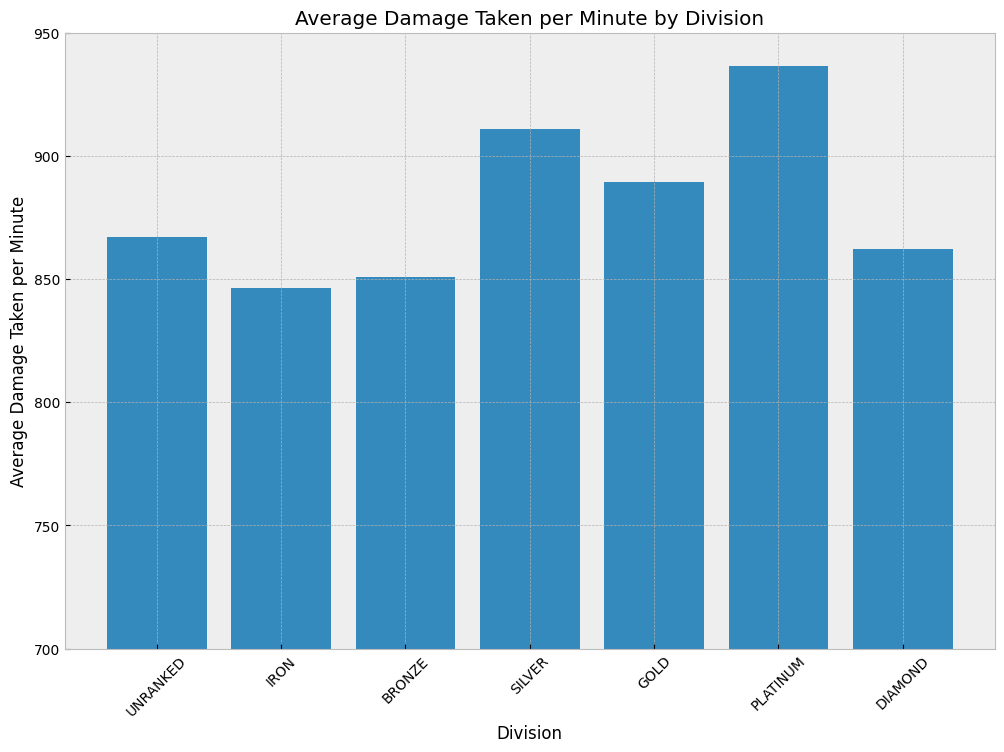

In [35]:
average_damage_taken['division'] = pd.Categorical(average_damage_taken['division'], categories=division_order, ordered=True)
average_damage_taken = average_damage_taken.sort_values('division')

plt.figure(figsize=(12, 8))
plt.bar(average_damage_taken['division'], average_damage_taken['dmg_taken_per_min'])
plt.xlabel('Division')
plt.ylabel('Average Damage Taken per Minute')
plt.title('Average Damage Taken per Minute by Division')
plt.xticks(rotation=45)
plt.ylim(700, 950)
plt.show()